## Test de CNN cardIAc

- suit l'article donné en documentation

In [366]:
import tensorflow as tf
import numpy as np
import numpy as np                   # For numerical operations (if needed for data manipulation)
import tensorflow as tf              # To build and train the model
from tensorflow.keras.models import Sequential  # For creating sequential models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout  # Layers used in the model
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels (if applicable)
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import serial


In [367]:
path_to_datasets = "../../neural_network/dataset_publications/datas/train_data"

# Training data
train_X_val = np.load(f"{path_to_datasets}/X.npy")

print(train_X_val.shape)

train_X_signal = train_X_val[::,:-2] # remove frequency at the end to get a good looking signal
train_X_freq = train_X_val[::,-2:] # frequency handled separately
print("train_X_signal shape :", train_X_signal.shape)

train_Y_temp = np.load(f"{path_to_datasets}/y_train.npy")
print("train_Y_temp shape :", train_Y_temp.shape)

# Test data
test_X_PCA = np.load(f"{path_to_datasets}/X_test.npy")
test_Y_temp = np.load(f"{path_to_datasets}/y_test.npy")


(5000, 183)
train_X_signal shape : (5000, 181)
train_Y_temp shape : (5000,)


In [368]:
# Vectorize Y for training and test
# Classes :
# - [0] : 'A' (Atrial premature contraction)
# - [1] : 'L' (Left bundle branch block fluctuation)
# - [2] : 'N' (Normal)
# - [3] : 'R' (Right bundle branch block fluctuation)
# - [4] : 'V' (premature ventricular contraction)

def vectorize_Y(arr):
    mapping = {'A': [1, 0, 0, 0, 0],
               'L': [0, 1, 0, 0, 0],
               'N': [0, 0, 1, 0, 0],
               'R': [0, 0, 0, 1, 0],
               'V': [0, 0, 0, 0, 1]}
    
    res = np.array([mapping[val] for val in arr])
    return res

def devectorize_Y(vectorized_arr):
    mapping = {(1, 0, 0, 0, 0): 'A',
               (0, 1, 0, 0, 0): 'L',
               (0, 0, 1, 0, 0): 'N',
               (0, 0, 0, 1, 0): 'R',
               (0, 0, 0, 0, 1): 'V'}
    res = np.array([mapping[tuple(vec)] for vec in vectorized_arr])
    return res

# Vectorize train and test data
train_Y = vectorize_Y(train_Y_temp)
test_Y = vectorize_Y(test_Y_temp)


## Printing dataset samples

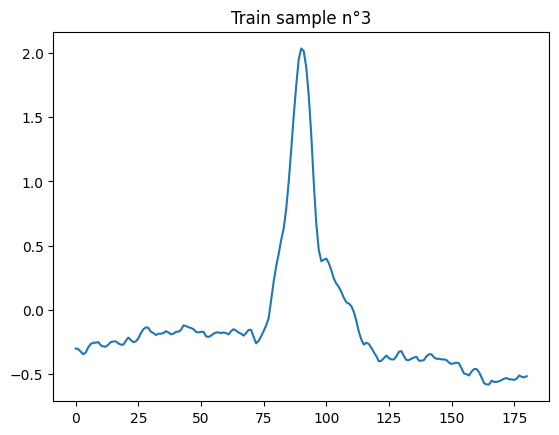

Time diff (prev/next) beat : [242. 246.]


In [369]:
index_shown = 3

plt.plot(np.arange(0, train_X_signal.shape[1]), train_X_signal[index_shown])

plt.title(f"Train sample n°{index_shown}")
plt.show()

print(f"Time diff (prev/next) beat : {train_X_freq[index_shown]}")


In [370]:
# Comptage des différentes classifications

def count_occurrences(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

count_occurrences(train_Y_temp)

{'A': 971, 'L': 995, 'N': 1038, 'R': 1029, 'V': 967}

# CNN 

In [371]:
# CNN Layers
# 2 inputs : signal and time between beats

signal_size = train_X_signal.shape
print("signal size :", signal_size)

# Create the model
model = Sequential()

# Input shape = (256, 1), filters = 4, kernel size = 21
model.add(Conv1D(filters=4, kernel_size=21, activation='relu', input_shape=(181, 1)))

# Pooling size chosen to reach 86, here kernel size = 3 with stride = 3
model.add(MaxPooling1D(pool_size=3, strides=3))

# Filters = 4, kernel size = 21
model.add(Conv1D(filters=4, kernel_size=21, activation='relu'))

# Pooling size chosen to reach 29, here kernel size = 3 with stride = 3
model.add(MaxPooling1D(pool_size=3, strides=3))

# Flatten the output to connect with the fully connected layer
model.add(Flatten())

# Small layers at the output
model.add(Dense(units=32, activation='relu'))

# Input size = 116 (29x4 after Flatten), output size = 5
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


signal size : (5000, 181)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_75 (Conv1D)              │ (None, 161, 4)         │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 53, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 33, 4)          │           340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 11, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033 (7.94 KB)

 Trainable params: 2,033 (7.94 KB)

 Non-trainable params: 0 (0.00 B)

(5000, 5)
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4351 - loss: 1.3245 - val_accuracy: 0.7710 - val_loss: 0.7548
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7847 - loss: 0.6745 - val_accuracy: 0.7180 - val_loss: 0.6623
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8173 - loss: 0.5371 - val_accuracy: 0.8320 - val_loss: 0.5299
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8339 - loss: 0.4615 - val_accuracy: 0.8490 - val_loss: 0.4577
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.4506 - val_accuracy: 0.8610 - val_loss: 0.4133
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8623 - loss: 0.3812 - val_accuracy: 0.8840 - val_loss: 0.3474
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8788 - loss: 0.3448 - val_accuracy: 0.8930 - val_loss: 0.3333
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8841 - loss: 0.3312 - val_ac

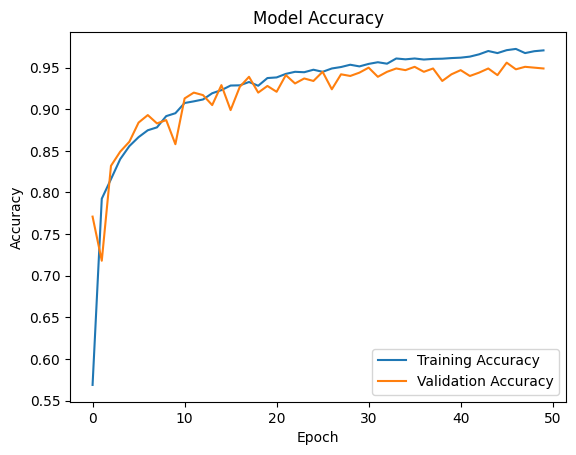

In [372]:
# Compile and train the model

print(train_Y.shape)

optimizer = Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_X_signal, 
    train_Y, 
    epochs = 50, 
    batch_size=32,
    validation_split=0.2
)

# Plot the accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [373]:
model.save("CNN_cardIAc.keras")